<a href="https://colab.research.google.com/github/anish-sk/CS6910_Assignment1/blob/master/src/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade wandb
!wandb login 6746f968d95eb71e281d6c7772a0469574430408

     |████████████████████████████████| 2.0MB 18.1MB/s 
     |████████████████████████████████| 133kB 54.2MB/s 
     |████████████████████████████████| 163kB 49.9MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=fd34b10e6301ea2493c4dc2037850abfcf36cac253d3fffe657aea7215971663
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=bb151e90ada51b0dd33d19cfb1cdddc850d0c0aa5458a6c726bc62b29370f930
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Init wandb
import wandb

# run = wandb.init(project="assignment1", entity="abisheks", reinit=True)

import numpy as np
import math
from matplotlib import pyplot as plt
# Loading the fashion mnist dataset
from keras.datasets import fashion_mnist
# Setting seed value
np.random.seed(1)

# Load dataset (train data and test data)
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

4423680/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [ ]:

# Number of classes in the Fashion-MNIST dataset
N_CLASSES = np.unique(trainy).shape[0]    # 10 as known from the keras documentation

# Captions/Labels for the output classes present in Fashion-MNIST dataset
IMG_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def getSampleImages(nClass, imgLabels, X, y, nSamples):
  '''
  The function takes few samples of each class from the dataset provided and passes it to the WANDB for it log the images

  Arguments :
    nClass -- Number of output classes in the dataset
    imgLabels -- List of labels for the output classes (numbered from 0 to nClass - 1)
    X -- The input data containing images in the form of matrices
    y -- The output data containing the class to which an input belongs
    nSamples -- Number of samples of each class to be taken. If that many samples not present in dataset, maximum number of samples present (from that class) will be taken

  Returns :
    -- None --
  '''

  # Initialise empty list to store the input data sampled from each class
  sampleImgsX = [[] for _ in range(nClass)]

  # Take 3 sample images from each class
  for i in range(y.shape[0]):
    if len(sampleImgsX[y[i]]) < nSamples :
      sampleImgsX[y[i]].append(X[i])


  # Getting a list of sample images of each class to be saved to wandb
  sampleImgsList = []
  for i in range(nClass):
    for j in range(3):
      sampleImgsList.append(wandb.Image(sampleImgsX[i][j], caption = imgLabels[i]))

  np.random.shuffle(sampleImgsList)
  wandb.log({"example" : sampleImgsList})


# Question 1 : Show 3 sample images from training set of downloaded Fashion-MNIST dataset in WANDB
# getSampleImages(N_CLASSES, IMG_LABELS, trainX, trainy, 3)
# run.finish()

In [ ]:
def relu(X):
  # Calculates the Rectified Linear Unit (ReLU) function
  return np.maximum(X,0)

def sigmoid(X):
  # Calculates the sigmoid function
  return np.exp(-np.logaddexp(0, -X))

def softmax(X):
  # Calculates the softmax function
  e_X = np.exp(X - np.max(X, axis = 0))
  return e_X / e_X.sum(axis = 0)

def tanh(X):
  return np.tanh(X)

def linear(W, X, b):
  # Calculates the linear function
  return W @ X + b

def grad_relu(X):
  # Calculates the gradient of Rectified Linear Unit (ReLU) function
  return X > 0

def grad_sigmoid(X):
  # Calculates the gradient of sigmoid function
  return sigmoid(X) * (1 - sigmoid(X))

def grad_tanh(X):
  # Calculates the gradient of tanh function
  return 1 - np.tanh(X)**2

def Softmax_CrossEntropy_grad(Y_pred, Y):
  # Calculates the gradient of the output layer with softmax activation and cross entropy loss
  # layer -- The dictionary for the output layer contianing info about it
  # y -- True output
  return -(Y - Y_pred)

def Softmax_SquaredError_grad(Y_pred, Y):
  return ((Y_pred - Y) - ((Y_pred - Y) * Y_pred).sum(axis = 0)) * Y_pred 

In [ ]:
def random_initialisation(shape):
  # Initialising a random matrix with given dimensions (shape) as tuple
  return np.random.randn(*shape)*0.1

def xavier_initialisation(shape):
  # Initialising a matrix by xavier initialisation with given dimensions (shape) as tuple
  bound = (6/(shape[0]+shape[1]))**(0.5)
  return bound*(2*np.random.rand(*shape)-1)

In [ ]:
def initialize_network(n_L, preActFns_L, actFns_L, gradActFns_L, gradOutputFn, weight_initialisation):
  '''
  The function initializes the neural network and the appropriate parameters
  
  Arguments :
    n_L -- an array whose ith element represents the number of neurons in the ith layer (0 - Input Layer, last element - Output Layer)
    preActFns_L -- an array who ith element is the Pre Activation function of the (i+1)th layer of the neural network
    actFns_L -- an array who ith element is the Activation function of the (i+1)th layer of the neural network
    gradActFns_L -- an array who ith element is the gradient of the Activation function of the (i+1)th layer of the neural network
    gradOutputFn -- Function to calculate gradients wrt a_L (output layer) in back-propagation
    weight_initialisation -- Function to initialise weights of the layers
  
  Returns :
    network -- the initialized network as an array of dictionaries for the hidden and output layers of the neural network
  '''

  L = len(n_L)-1

  assert(L >= 1)
  assert(len(preActFns_L) == L)
  assert(len(actFns_L) == L)

  network = list()
  for i in range(1,L+1):
    # Dictionary for each layer representing it's constituents
    layer = {'weights':weight_initialisation((n_L[i],n_L[i-1])),  # Weight matrix for (i-1)th to ith layer transition
             'biases':np.zeros((n_L[i],1)),                       # Bias vector for (i-1)th to ith layer transition
             'pre_activation_fn':preActFns_L[i-1],                # Pre-activation function for neurons of the ith layer
             'activation_fn':actFns_L[i-1],                       # Activation function for neurons of the ith layer             
             'no_neurons':n_L[i],                                 # Number of neurons in ith layer
             'cache': []                                          # Array of cached pre-activation and activation output for each layer to be used in back-propagation (will be filled in forward-propagation)
            }
    network.append(layer)	
    if i < L:
      network[-1]['grad_activation_fn'] = gradActFns_L[i-1]       # Function calculating Gradient of the Activation function for the ith (hidden) layer
  
  network[-1]['grad_output_fn'] = gradOutputFn                    # Function calculating Gradient of the Output layer (Gradient of Loss function wrt a_L)

  return network


In [ ]:
def pre_activation(H_prev, W, b, pre_activation_fn):
  # Calculates the pre-activation output and caches the required values. Returns the output and cache.

  A = pre_activation_fn(W, H_prev, b)
  
  assert(A.shape[0] == W.shape[0])
  pre_act_cache = H_prev                    # Caching the pre-activation ouptut to be used in backpropagation

  return A, pre_act_cache

def feedforward_neuron(H_prev, W, b, activation_fn, pre_activation_fn):
  # Calculates the activation output (using the pre-activation function above) and caches the required values. Returns the output and cache.

  A, pre_activation_cache = pre_activation(H_prev, W, b, pre_activation_fn)
  H = activation_fn(A)
  
  assert (H.shape[0] == W.shape[0])
  cache = (pre_activation_cache, A)         # Caching the pre-activation and activation output to use it in back-propagation

  return H, cache

In [ ]:
def forward_propagation(network, X):
    """
    Implement forward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      X -- Input data from the training set as a matrix with ith column representing ith input training data
    
    Returns :
      Output from the neural network as a matrix with ith column representing output of ith input data
    """

    H = X                         # Initialising H to input
    L = len(network)              # Number of (hidden + output) layers in the neural network

    for l in range(0, L):
        H_prev = H 
        H, cache = feedforward_neuron(H_prev, network[l]['weights'], network[l]['biases'], network[l]['activation_fn'], network[l]['pre_activation_fn'])
        network[l]['cache'] = cache
    
    assert(H.shape[0] == (network[L-1]['no_neurons']))
        
    return H

# HL = forward_propagation(trainX_reshaped, network)          # HL -- output from the neural network
# print(HL)

In [ ]:
 def back_propagation(network, Y, Y_pred, weight_decay, grad_reglr_fn):
  """
    Implement backward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      Y -- True output matrix with ith column representing true output of ith input data
      Y_pred -- Output of neural network as a matrix in the same form as Y
      weight_decay -- Hyperparameter scaling regularisation term
      grad_reglr_fn -- Function calculating gradient of the regularisation function
    
    Returns :
      H -- Output from the neural network
  """

  L = len(network)
  assert(Y.shape[1] == Y_pred.shape[1])
  M = Y.shape[1]

  # Gradients wrt output layer (a_L)
  grad_a_k_L = network[L-1]['grad_output_fn'](Y_pred, Y)

  # Initialising gradients to be calculated in the loop below
  grad_w_L = [np.zeros(2)] * L
  grad_b_L = [np.zeros(2)] * L
  grad_h_prev_L, grad_a_prev_L = 0, 0

  for k in range(L-1,-1,-1):
    # Gradients wrt Weights (W_k)
    grad_w_L[k] = (grad_a_k_L @ network[k]['cache'][0].T / M) + weight_decay * grad_reglr_fn(network[k]['weights'])

    # Gradients wrt Biases (b_k)
    grad_b_L[k] = np.mean(grad_a_k_L, axis=1)
    grad_b_L[k] = grad_b_L[k].reshape((grad_b_L[k].shape[0], 1))
    
    # Gradients wrt hidden layer
    # Gradients wrt h_(k-1)
    grad_h_prev_L = network[k]['weights'].T @ grad_a_k_L

    # Gradients wrt a_(k-1)
    if(k > 0):
      grad_act_fn_prev = network[k-1]['grad_activation_fn'](network[k-1]['cache'][1])
      grad_a_prev_L = grad_h_prev_L * grad_act_fn_prev

    grad_a_k_L = grad_a_prev_L

  return grad_w_L, grad_b_L

In [ ]:
def L2_regularisation(network):
  # Function that returns L2 regularisation loss for the given network
  L = len(network)
  ans = 0
  for k in range(L):
    ans += np.sum(network[k]['weights'] ** 2)
  
  return ans

def L1_regularisation(network):
  # Function that returns L1 regularisation loss for the given network
  L = len(network)
  ans = 0
  for k in range(L):
    ans += np.sum(np.absolute(network[k]['weights']))
  
  return ans

def grad_L2_regularisation(W):
  # Function that returns L2 regularisation gradient for the given Weight matrix / tensor
  return 2 * W

def grad_L1_regularisation(W):
  # Function that returns L1 regularisation gradient for the given Weight matrix / tensor
  return np.sign(W)

In [ ]:
def CrossEntropy_loss(Y_pred, Y_true):
  # Function that returns cross entropy loss
  assert(Y_pred.shape[1] == Y_true.shape[1])
  M = Y_pred.shape[1]
  return -(Y_true * np.log(Y_pred)).sum() / M

def SquaredError(Y_pred, Y_true):
  # Function that returns mean squared loss
  assert(Y_pred.shape[1] == Y_true.shape[1])
  M = Y_pred.shape[1]
  return ((Y_true - Y_pred) ** 2).sum() / (2.0 * M)

def overall_loss(network, Y_pred, Y_true, loss_fn = CrossEntropy_loss, weight_decay = 0, regularisation_fn = L2_regularisation):
  # Function that returns overall loss (Output layer cost function + Regularisation) for the network
  return loss_fn(Y_pred, Y_true) + weight_decay * regularisation_fn(network)


In [ ]:
  def calc_accuracy_loss(network, X, Y, loss_fn = CrossEntropy_loss, weight_decay = 0, regularisation_fn = L2_regularisation):
    # Function that returns the accuracy and loss for a given network
    Y_pred = forward_propagation(network, X)
    loss = overall_loss(network, Y_pred, Y, loss_fn, weight_decay, regularisation_fn)
    assert(X.shape[1] == Y.shape[1])
    M = X.shape[1]
    accuracy = np.sum(np.argmax(Y_pred, axis = 0) == np.argmax(Y, axis = 0)) / M
    return accuracy, loss

In [ ]:
from tqdm import tqdm

def sgd_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, weight_decay = 0, 
                         regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None):
  """
    Trains the neural network using Vanilla/Batch Gradient Descent
    
    Arguments :
      X -- Input training data matrix where ith column is the input data corresponding to ith training example
      Y -- True training output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)
      
    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]
  
  for epoch in tqdm(range(max_epochs)):        
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
      dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        network[k]['weights'] -= eta * dw[k]
        network[k]['biases'] -= eta * db[k]
    
    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))

    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0], 
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})
  
  return batch_loss_values, train_stats, valid_stats


In [ ]:
def momentum_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, beta = 0.9, weight_decay = 0, 
                              regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None):
  """
    Trains the neural network using Momentum Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      beta -- Hyperparameter to tune dependency of gradient on history
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)
      
    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, m_w, m_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                     [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  for epoch in tqdm(range(max_epochs)):  
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
      dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        m_w[k] = m_w[k] * beta + dw[k] * eta
        m_b[k] = m_b[k] * beta + db[k] * eta
        network[k]['weights'] -= m_w[k]
        network[k]['biases'] -= m_b[k]
  
    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))

    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0], 
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})
  
  return batch_loss_values, train_stats, valid_stats


def nesterov_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, beta = 0.9, weight_decay=0, 
                              regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None):
  """
    Trains the neural network using Nesterov Accelerated Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      beta -- Hyperparameter to tune dependency of gradient on history
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)
      
    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])
  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, m_w, m_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                     [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  lookahead_network = network[:]

  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred_org = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred_org, Y_true, loss_fn, weight_decay, regularisation_fn)
      Y_pred = forward_propagation(lookahead_network, X[:,i:i+batch_size])
      dw, db = back_propagation(lookahead_network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        m_w[k] = m_w[k] * beta + dw[k] * eta
        m_b[k] = m_b[k] * beta + db[k] * eta
        network[k]['weights'] -= m_w[k]
        network[k]['biases'] -= m_b[k] 
        lookahead_network[k]['weights'] -= (eta * dw[k] + beta * m_w[k])
        lookahead_network[k]['biases'] -= (eta * db[k] + beta * m_b[k])

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))
    
    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0], 
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats


In [ ]:
def rmsprop_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, eps = 1e-8, beta = 0.9,
                             weight_decay=0, regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, 
                             validX = None, validY = None):
  """
    Trains the neural network using RMSProp Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta -- Hyperparameter acting as decaying weight for learning rate update
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)
      
    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])
    
  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0

  dw, db, v_w, v_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                     [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  for epoch in tqdm(range(max_epochs)):  
    for i in range(0, X.shape[1], batch_size):
        batch += 1
        Y_true = Y[:,i:i+batch_size]
        Y_pred = forward_propagation(network, X[:,i:i+batch_size])
        batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
        dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
        batch_loss_values.append(batch_curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
        for k in range(L):
          v_w[k] = v_w[k] * beta + (1-beta) * dw[k]**2
          v_b[k] = v_b[k] * beta + (1-beta) * db[k]**2
          network[k]['weights'] -= (eta / np.sqrt(v_w[k] + eps)) * dw[k]
          network[k]['biases'] -= (eta / np.sqrt(v_b[k] + eps)) * db[k]
    
    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))
    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0], 
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats


In [ ]:
def adam_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 50, loss_fn = CrossEntropy_loss, eps = 1e-8, beta1 = 0.9, 
                          beta2 = 0.999, weight_decay=0, regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, 
                          validX = None, validY = None):
  """
    Trains the neural network using Adam Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta1 -- Hyperparameter acting as decaying weight for momentum update
      beta2 -- Hyperparameter acting as decaying weight for learning rate update
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)
      
    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])
  
  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, v_w, v_b, m_w, m_b, = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                                [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                                [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]
  
  for epoch in tqdm(range(max_epochs)):  
    for i in range(0, X.shape[1], batch_size):
        batch += 1
        Y_true = Y[:,i:i+batch_size]
        Y_pred = forward_propagation(network, X[:,i:i+batch_size])
        batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
        dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
        batch_loss_values.append(batch_curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
        for k in range(L):
          m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
          m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
          v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
          v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
          m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
          m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
          v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
          v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
          network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * m_w_hat
          network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * m_b_hat

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))
    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0], 
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})
  
  return batch_loss_values, train_stats, valid_stats
  

In [ ]:
# Nadam optimisation followed from this paper : https://arxiv.org/pdf/1609.04747.pdf
def nadam_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, eps = 1e-8, beta1 = 0.9, 
                           beta2 = 0.999, weight_decay=0, regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, 
                           validX = None, validY = None):
  """
    Trains the neural network using Nadam Accelerated Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta1 -- Hyperparameter acting as decaying weight for momentum update
      beta2 -- Hyperparameter acting as decaying weight for learning rate update
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)
      
    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (accuracy, average loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, m_w, m_b, v_w, v_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                               [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                               [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]


  for epoch in tqdm(range(max_epochs)):  
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
      dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
        m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
        v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
        v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
        m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
        m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
        v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
        v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
        network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * (m_w_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * dw[k])
        network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * (m_b_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * db[k])

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))
    
    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0], 
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})
  
  return batch_loss_values, train_stats, valid_stats


In [ ]:
def convert_to_onehot(Y, N) :
  # Converting output data Y to onehot representation
  Y_onehot = []
  for y in Y:
    curr_y = [0] * N
    curr_y[y] = 1
    Y_onehot.append(curr_y)

  return np.array(Y_onehot).T

def train_validation_split(X, Y, train_to_valid_ratio = 0.9):
  # Function to split the given input and output data into training and validation sets in the ratio given by train_to_valid_ratio
  assert(train_to_valid_ratio > 0 and train_to_valid_ratio < 1)

  perm = np.random.permutation(trainX.shape[0])
  train_size = int(train_to_valid_ratio * len(perm))
  train_indices = perm[:train_size]
  valid_indices = perm[train_size:]

  return X[train_indices], Y[train_indices], X[valid_indices], Y[valid_indices]

def transform_NN_IO(X, Y, no_output_class):
  # Function to transform the input and output to a form compatible with the Neural Network functions
  X_norm = X.reshape(X.shape[0], (X.shape[1]*X.shape[2])).T / 255   # Input Training data with ith column being ith training example's data
  Y_onehot = convert_to_onehot(Y, no_output_class)                  # Converting y labels to onehot representation

  return X_norm, Y_onehot


In [ ]:
# Encoding the functions with strings for using in sweep
get_grad = {
    'sigmoid' : grad_sigmoid,
    'tanh' : grad_tanh,
    'relu' : grad_relu
}

get_gd_function = {
    'sgd' : sgd_gradient_descent, 
    'momentum' : momentum_gradient_descent, 
    'nesterov' : nesterov_gradient_descent, 
    'rmsprop' : rmsprop_gradient_descent, 
    'adam' : adam_gradient_descent, 
    'nadam' : nadam_gradient_descent 
}

get_activ_fn = {
    'sigmoid' : sigmoid,
    'tanh' : tanh,
    'relu' : relu
}

get_weight_init_fn = {
    'random': random_initialisation, 
    'xavier': xavier_initialisation
}

get_regularisation_fn = {
    'L2': L2_regularisation,
    'L1': L1_regularisation
}

get_grad_reglr_fn = {
    'L2': grad_L2_regularisation,
    'L1': grad_L1_regularisation
}


def train_NN(trainX, trainY, optimisation_fn, batch_size, learning_rate, max_epochs, no_hidden_layers, size_hidden_layer, weight_initialisation_fn,
             activation_fn, pre_activation_fn = linear, output_fn = softmax, grad_act_fn = grad_sigmoid, 
             grad_output_fn = Softmax_CrossEntropy_grad, loss_fn = CrossEntropy_loss, weight_decay = 0, regularisation_fn = L2_regularisation,
             grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None, testX = None, testY = None):
  
  # Setting the hyperparameters in the wandb
  wandb.config.update({"no_hidden_layers": no_hidden_layers, 
                       "size_hidden_layer": size_hidden_layer,
                       "batch_size": batch_size,
                       "learning_rate": learning_rate,
                       "no_epochs": max_epochs,
                      })
  
  assert(trainX.shape[1] == trainY.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])
  if testY is not None:
    assert(testX.shape[1] == testY.shape[1])
    
  L = no_hidden_layers+1                                # Number of hidden layerws + Output layer in the neural network
  n_L = [size_hidden_layer] * (L+1)                     # List of number of neurons in the neural network

  n_L[0] = trainX.shape[0]
  n_L[L] = trainY.shape[0]

  pre_act_fns_L = [pre_activation_fn] * L               # List of Pre-activation functions of the hidden layers and output layer
  act_fns_L = [activation_fn] * (L-1) + [output_fn]     # List of Activation functions of the hidden layers and output layer
  grad_act_fns_L = [grad_act_fn] * (L-1)                # List of Gradients of the Activation functions, of the hidden layers

  network = initialize_network(n_L, pre_act_fns_L, act_fns_L, grad_act_fns_L, grad_output_fn, weight_initialisation_fn)
  batch_loss_values, train_stats, valid_stats = optimisation_fn(trainX, trainY, network, batch_size, learning_rate, max_epochs, 
                                                                loss_fn, weight_decay = weight_decay, regularisation_fn = regularisation_fn, 
                                                                grad_reglr_fn = grad_reglr_fn, validX = validX, validY = validY)
  if testY is not None: 
    test_stats = calc_accuracy_loss(network, testX, testY, loss_fn, weight_decay, regularisation_fn)
    wandb.log({'test_accuracy': test_stats[0], 'test_loss': test_stats[1]})
    print(test_stats)

  plt.plot(batch_loss_values)
  plt.show()
  # plt.plot(train_stats[:][0])
  # plt.show()
  # plt.plot(train_stats[:][1])
  # plt.show()

  return network

100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


(0.7964, 0.20125937010194261)


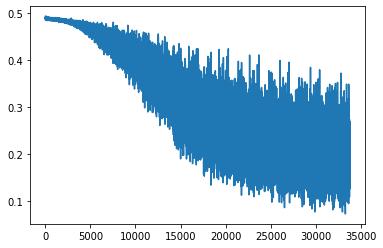

batch,33750
epoch,9
batch_loss,0.10964
_runtime,35
_timestamp,1615458620
_step,33760
validation_accuracy,0.80033
accuracy,0.80978
validation_loss,0.20101
loss,0.19523
test_accuracy,0.7964


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
batch_loss,███████▇▇▇▇▆▆▆▆▆▆▄▄▄▃▆▄▃▄▄▄▃▃▃▂▃▄▂▃▃▁▂▃▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_accuracy,▁▁▃▅▆▇▇▇██
accuracy,▁▁▃▅▆▇▇▇██
validation_loss,█▇▆▅▃▃▂▂▁▁
loss,█▇▆▅▃▃▂▂▁▁
test_accuracy,▁


In [ ]:
trainX_split, trainY_split, validX_split, validY_split = train_validation_split(trainX, trainy, 0.9)
trainX_tr, trainY_tr = transform_NN_IO(trainX_split, trainY_split, N_CLASSES)
validX_tr, validY_tr = transform_NN_IO(validX_split, validY_split, N_CLASSES)
testX_tr, testY_tr = transform_NN_IO(testX, testy, N_CLASSES)

# Questions 2,3
# run = wandb.init(project="assignment1", entity="abisheks", reinit=True)
# network = train_NN(trainX_tr, trainY_tr, sgd_gradient_descent, 16, 1e-2, 10, 2, 10, random_initialisation, tanh, linear, softmax, grad_tanh,
#                    grad_output_fn = Softmax_SquaredError_grad, loss_fn = SquaredError,
#                    weight_decay = 0.0005, validX = validX_tr, validY = validY_tr, testX = testX_tr, testY = testY_tr)
# run.finish()

In [ ]:
sweep_config = {
    'method': 'bayes',                   # Possible search : grid, random, bayes
    'metric': {
      'name': 'validation_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'no_epochs': {
            'values': [5, 10]
        },
        'no_hidden_layers': {
            'values': [3, 4, 5]
        },
        'size_hidden_layer': {
            'values': [32, 64, 128]
        },
        'weight_decay' :{
            'values': [0, 0.005, 0.0005]
        },
        'learning_rate': {
            'values': [1e-1, 1e-2, 1e-3]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam' ]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_initialisation': {
            'values': ['random', 'xavier']
        },
        'activation_fn': {
            'values': ['relu', 'tanh', 'sigmoid']
        }
    }
}

# sweep_id = wandb.sweep(sweep_config, entity="abisheks", project="assignment1")

In [ ]:
def sweep_wrapper():
  # Default values for hyper-parameters we're going to sweep over
  config_defaults =  {
      'no_epochs': 5,
      'no_hidden_layers': 3,
      'size_hidden_layer': 32, 
      'weight_decay' : 0,
      'learning_rate': 1e-2,
      'optimizer': 'adam',
      'batch_size': 128,
      'weight_initialisation': 'random', 
      'activation_fn': 'relu'
  }

  # Initialize a new wandb run
  run = wandb.init(config=config_defaults, reinit=True)
  
  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config
  wandb.config.update({'no_classes': N_CLASSES})

  wandb.run.name = f'hl_{config.no_hidden_layers}_bs_{config.batch_size}_ac_{config.activation_fn}'
  wandb.run.save()

  train_NN(trainX_tr, trainY_tr, get_gd_function[config.optimizer], config.batch_size, config.learning_rate, 
           config.no_epochs, config.no_hidden_layers, config.size_hidden_layer, get_weight_init_fn[config.weight_initialisation],
           get_activ_fn[config.activation_fn], linear, softmax, get_grad[config.activation_fn], 
           Softmax_SquaredError_grad, SquaredError, config.weight_decay, L2_regularisation, grad_L2_regularisation, 
           validX_tr, validY_tr, testX_tr, testY_tr)
  
  run.finish()



In [ ]:
# Questions 4-6
# wandb.agent('abisheks/assignment1/9ks8kwx5', sweep_wrapper)

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1458, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1594, in _on_finish
    self.history._flush()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_history.py", line 59, in _flush
    self._callback(row=self._data, step=self._step)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 790, in _history_callback
    row, step, publish_step=not_using_tensorboard
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 212, in publish_history
    data = data_types.history_dict_to_json(run, data, step=step)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/data_types.py", line 1995, in history_dict_to_json
    payload[key] = val_to_json(run, key, val, namespace=step)
  File "/usr/local/lib/python3.7/dist

100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


(0.8664, 0.508516715371562)


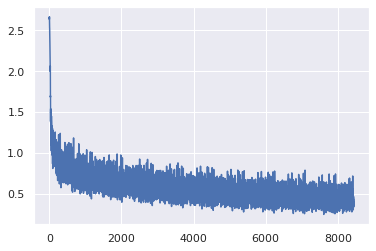

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



batch,8440
epoch,9
batch_loss,0.33399
_runtime,67
_timestamp,1615460254
_step,8451
validation_accuracy,0.86567
accuracy,0.8953
validation_loss,0.51262
loss,0.42632
test_accuracy,0.8664


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
batch_loss,█▇▆▇▆▄▆▄▄▅▄▄▃▃▃▃▂▃▄▂▅▅▃▁▄▂▄▃▂▃▂▂▁▄▂▃▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_accuracy,▁▃▄▅▅▆▆▇██
accuracy,▁▃▄▅▆▆▇▇██
validation_loss,█▆▅▄▃▃▂▂▁▁
loss,█▆▅▄▃▃▂▂▁▁
test_accuracy,▁


In [ ]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(network, X, Y):
  # Function to plot the confusion matrix for a given trained network, input (X) and true output (Y)
  Y_pred = forward_propagation(network, X)
  cm = confusion_matrix(np.argmax(Y, axis=0), np.argmax(Y_pred, axis=0))

  df_cm = pd.DataFrame(cm, [IMG_LABELS[i] for i in range(cm.shape[0])], [IMG_LABELS[i] for i in range(cm.shape[0])])
  plt.figure(figsize=(20,20))
  sn.set(font_scale=1.0) # for label size
  sn.heatmap(df_cm, annot=True, 
            annot_kws={"size": 16}, cmap='flare', fmt='g'
            ) # font size
  # plt.show()
  wandb.log({'Confusion Matrix': plt})

# Question 7
run = wandb.init(project="assignment1", entity="abisheks", reinit=True)
network = train_NN(trainX_tr, trainY_tr, momentum_gradient_descent, 64, 1e-2, 10, 4, 128, xavier_initialisation, relu, linear, softmax, grad_relu,
                   grad_output_fn = Softmax_CrossEntropy_grad, loss_fn = CrossEntropy_loss,
                   weight_decay = 0.0005, validX = validX_tr, validY = validY_tr, testX = testX_tr, testY = testY_tr)

plot_confusion_matrix(network, testX_tr, testY_tr)
run.finish()

